Math 5750/6880: Mathematics of Data Science \
Project 3

# 1. Fashion-MNIST image classification using sklearn

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
from sklearn.preprocessing import StandardScaler

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(len(X_train), -1)
X_test  = X_test.reshape(len(X_test), -1)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training time for MLP: 32.1355 seconds
Accuracy for MLP: 0.8777


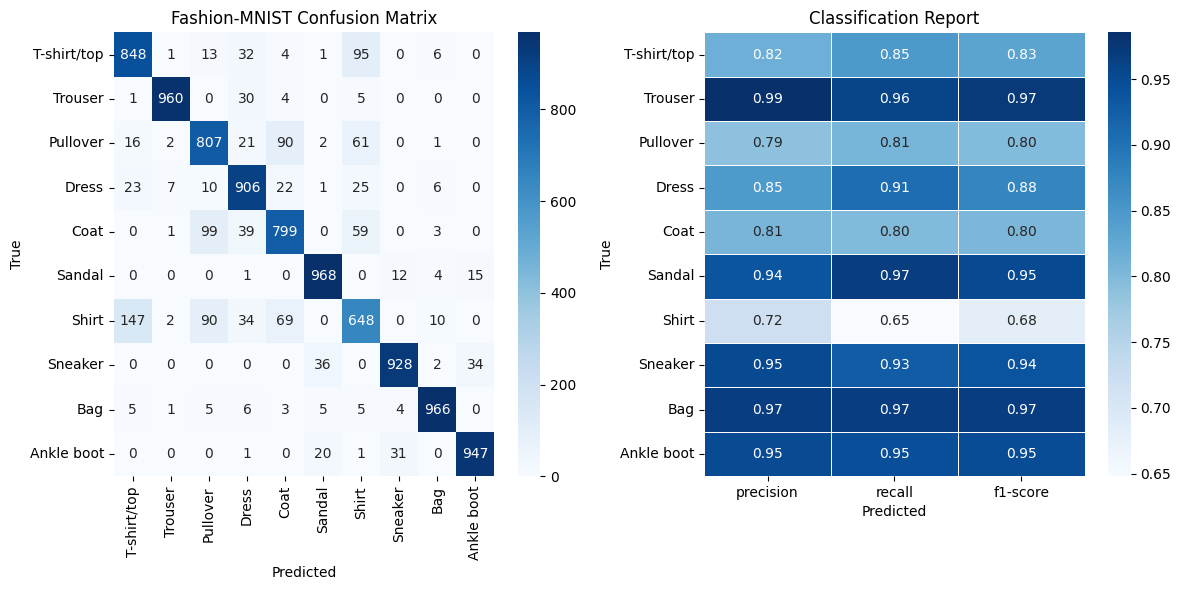

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Training time for MLP No Early Stopping: 2.0900 seconds
Accuracy for MLP No Early Stopping: 0.8394


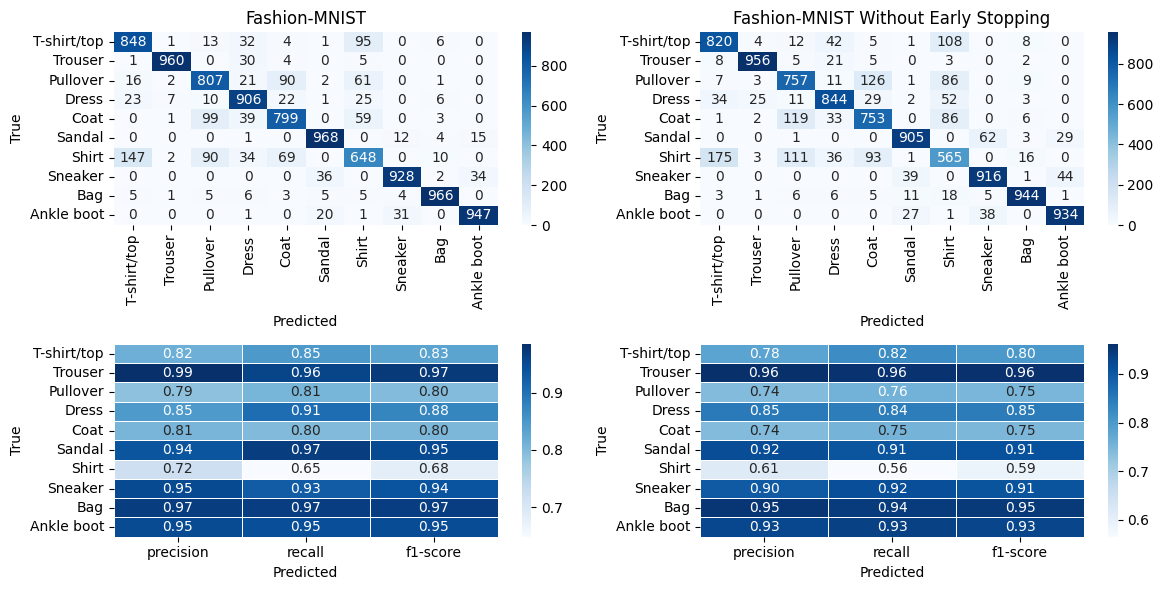

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

mlp = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

#The following options were tried to generate the graphics for the report. Only one was changed at a time.
#(100, )(Default), (128, 64), (50, 50, 50)
#Activation function: logistic, tanh, relu(Defalut)
#Solver: sgd, adam(Default)
#Alpha=0.001(Default), 0.0001

STD = time.perf_counter()

mlp.fit(X_train, y_train)

ETD = time.perf_counter()

print(f"Training time for MLP: {ETD - STD:0.4f} seconds")

y_pred = mlp.predict(X_test)

ADefault = accuracy_score(y_test, y_pred)
print(f"Accuracy for MLP: {ADefault}")

CRDefault = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefault:
    del CRDefault['accuracy']
if 'macro avg' in CRDefault:
    del CRDefault['macro avg']
if 'weighted avg' in CRDefault:
    del CRDefault['weighted avg']

CMDefault = confusion_matrix(y_test, y_pred)

#Plot for MLP
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax2, cmap='Blues', fmt='.2f', linewidths=.5)
ax2.set_title('Classification Report')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax1, cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
ax1.set_title("Fashion-MNIST Confusion Matrix")

plt.tight_layout()
plt.show()

#Default settings without stopping
mlpDNS = MLPClassifier(
    hidden_layer_sizes=(100, ), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    max_iter=200, #To pevent it from taking forever
    random_state=1)

STDNS = time.perf_counter()

mlpDNS.fit(X_train, y_train)

ETDNS = time.perf_counter()

print(f"Training time for MLP No Early Stopping: {ETDNS - STDNS:0.4f} seconds")

y_predDNS = mlpDNS.predict(X_test)

ADefaultNS = accuracy_score(y_test, y_predDNS)
print(f"Accuracy for MLP No Early Stopping: {ADefaultNS}")

CRDefaultNS = classification_report(y_test, y_predDNS, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefaultNS:
    del CRDefaultNS['accuracy']
if 'macro avg' in CRDefaultNS:
    del CRDefaultNS['macro avg']
if 'weighted avg' in CRDefaultNS:
    del CRDefaultNS['weighted avg']

CMDefaultNS = confusion_matrix(y_test, y_predDNS)

#Plot for MLP vs MLPNS
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax[1,0], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax[0,0], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,0].set_xlabel("Predicted")
ax[0,0].set_ylabel("True")
ax[0,0].set_title("Fashion-MNIST")

sns.heatmap(pd.DataFrame(CRDefaultNS).iloc[:-1, :].T, annot=True, ax=ax[1,1], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('True')

sns.heatmap(CMDefaultNS, annot=True, fmt="d", ax=ax[0,1], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,1].set_xlabel("Predicted")
ax[0,1].set_ylabel("True")
ax[0,1].set_title("Fashion-MNIST Without Early Stopping")

plt.tight_layout()
plt.show()

mlpSGD = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='sgd', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

STsgd = time.perf_counter()

mlpSGD.fit(X_train, y_train)

ETsgd = time.perf_counter()

print(f"Training time for MLP SGD: {ETsgd - STsgd:0.4f} seconds")

y_predSGD = mlpSGD.predict(X_test)

ADefaultSGD = accuracy_score(y_test, y_predSGD)
print(f"Accuracy for MLP SGD: {ADefaultSGD}")

CRDefaultSGD = classification_report(y_test, y_predSGD, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefaultSGD:
    del CRDefaultSGD['accuracy']
if 'macro avg' in CRDefaultSGD:
    del CRDefaultSGD['macro avg']
if 'weighted avg' in CRDefaultSGD:
    del CRDefaultSGD['weighted avg']

CMDefaultSGD = confusion_matrix(y_test, y_predSGD)

#Plot for MLP different solvers
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax[1,0], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax[0,0], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,0].set_xlabel("Predicted")
ax[0,0].set_ylabel("True")
ax[0,0].set_title("Fashion-MNIST ADAM")

sns.heatmap(pd.DataFrame(CRDefaultSGD).iloc[:-1, :].T, annot=True, ax=ax[1,1], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('True')

sns.heatmap(CMDefaultSGD, annot=True, fmt="d", ax=ax[0,1], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,1].set_xlabel("Predicted")
ax[0,1].set_ylabel("True")
ax[0,1].set_title("Fashion-MNIST SGD")

plt.tight_layout()
plt.show()

mlp001 = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

ST001 = time.perf_counter()

mlp001.fit(X_train, y_train)

ET001 = time.perf_counter()

print(f"Training time for MLP Alpha = .001: {ET001 - ST001:0.4f} seconds")

y_pred001 = mlp001.predict(X_test)

ADefault001 = accuracy_score(y_test, y_pred001)
print(f"Accuracy for MLP Alpha = .001: {ADefault001}")

CRDefault001 = classification_report(y_test, y_pred001, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefault001:
    del CRDefault001['accuracy']
if 'macro avg' in CRDefault001:
    del CRDefault001['macro avg']
if 'weighted avg' in CRDefault001:
    del CRDefault001['weighted avg']

CMDefault001 = confusion_matrix(y_test, y_pred001)

#Plot for MLP different alpha
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax[1,0], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax[0,0], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,0].set_xlabel("Predicted")
ax[0,0].set_ylabel("True")
ax[0,0].set_title("Fashion-MNIST Alpha = .0001")

sns.heatmap(pd.DataFrame(CRDefault001).iloc[:-1, :].T, annot=True, ax=ax[1,1], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('True')

sns.heatmap(CMDefault001, annot=True, fmt="d", ax=ax[0,1], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,1].set_xlabel("Predicted")
ax[0,1].set_ylabel("True")
ax[0,1].set_title("Fashion-MNIST Alpha = .001")

plt.tight_layout()
plt.show()

mlp12864 = MLPClassifier(
    hidden_layer_sizes=(128, 64), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

ST12864 = time.perf_counter()

mlp12864.fit(X_train, y_train)

ET12864 = time.perf_counter()

print(f"Training time for MLP 128x50: {ET12864 - ST12864:0.4f} seconds")

y_pred12864 = mlp12864.predict(X_test)

ADefault12864 = accuracy_score(y_test, y_pred12864)
print(f"Accuracy for MLP 128x50: {ADefault12864}")

CRDefault12864 = classification_report(y_test, y_pred12864, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefault12864:
    del CRDefault12864['accuracy']
if 'macro avg' in CRDefault12864:
    del CRDefault12864['macro avg']
if 'weighted avg' in CRDefault12864:
    del CRDefault12864['weighted avg']

CMDefault12864 = confusion_matrix(y_test, y_pred12864)

#This is the default 100 1. 50, 50, 50 was moved to the default as it was faster and this was left to avoid renaming everything.
mlp505050 = MLPClassifier(
    hidden_layer_sizes=(100, ), #Number of hidden layers and neurons
    activation='relu', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

ST505050 = time.perf_counter()

mlp505050.fit(X_train, y_train)

ET505050 = time.perf_counter()

print(f"Training time for MLP 100, 1: {ET505050 - ST505050:0.4f} seconds")

y_pred505050 = mlp505050.predict(X_test)

ADefault505050 = accuracy_score(y_test, y_pred505050)
print(f"Accuracy for MLP 100, 1: {ADefault505050}")

CRDefault505050 = classification_report(y_test, y_pred505050, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefault505050:
    del CRDefault505050['accuracy']
if 'macro avg' in CRDefault505050:
    del CRDefault505050['macro avg']
if 'weighted avg' in CRDefault505050:
    del CRDefault505050['weighted avg']

CMDefault505050 = confusion_matrix(y_test, y_pred505050)

#Plot for MLP different NN Layers
fig, ax = plt.subplots(2, 3, figsize=(18, 6))

sns.heatmap(pd.DataFrame(CRDefault505050).iloc[:-1, :].T, annot=True, ax=ax[1,0], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('True')

sns.heatmap(CMDefault505050, annot=True, fmt="d", ax=ax[0,0], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,0].set_xlabel("Predicted")
ax[0,0].set_ylabel("True")
ax[0,0].set_title("Fashion-MNIST 100x1")

sns.heatmap(pd.DataFrame(CRDefault12864).iloc[:-1, :].T, annot=True, ax=ax[1,1], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('True')

sns.heatmap(CMDefault12864, annot=True, fmt="d", ax=ax[0,1], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,1].set_xlabel("Predicted")
ax[0,1].set_ylabel("True")
ax[0,1].set_title("Fashion-MNIST 128x50")

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax[1,2], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,2].set_xlabel('Predicted')
ax[1,2].set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax[0,2], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,2].set_xlabel("Predicted")
ax[0,2].set_ylabel("True")
ax[0,2].set_title("Fashion-MNIST 50x50x50")

plt.tight_layout()
plt.show()

mlptanh = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='tanh', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

STtanh = time.perf_counter()

mlptanh.fit(X_train, y_train)

ETtanh = time.perf_counter()

print(f"Training time for MLP Tanh: {ETtanh - STtanh:0.4f} seconds")

y_predtanh = mlptanh.predict(X_test)

ADefaulttanh = accuracy_score(y_test, y_predtanh)
print(f"Accuracy for MLP Tanh: {ADefaulttanh}")

CRDefaulttanh = classification_report(y_test, y_predtanh, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefaulttanh:
    del CRDefaulttanh['accuracy']
if 'macro avg' in CRDefaulttanh:
    del CRDefaulttanh['macro avg']
if 'weighted avg' in CRDefaulttanh:
    del CRDefaulttanh['weighted avg']

CMDefaulttanh = confusion_matrix(y_test, y_predtanh)

mlplogistic = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50), #Number of hidden layers and neurons
    activation='logistic', #Activation function
    solver='adam', #Optimization method and the learning rate
    alpha=0.0001, #Regularization
    early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, #Early stopping
    max_iter=200, #To pevent it from taking forever
    random_state=1)

STlogistic = time.perf_counter()

mlplogistic.fit(X_train, y_train)

ETlogistic = time.perf_counter()

print(f"Training time for MLP Logistic: {ETlogistic - STlogistic:0.4f} seconds")

y_predlogistic = mlplogistic.predict(X_test)

ADefaultlogistic = accuracy_score(y_test, y_predlogistic)
print(f"Accuracy for MLP Logistic: {ADefaultlogistic}")

CRDefaultlogistic = classification_report(y_test, y_predlogistic, target_names=class_names, output_dict=True)
if 'accuracy' in CRDefaultlogistic:
    del CRDefaultlogistic['accuracy']
if 'macro avg' in CRDefaultlogistic:
    del CRDefaultlogistic['macro avg']
if 'weighted avg' in CRDefaultlogistic:
    del CRDefaultlogistic['weighted avg']

CMDefaultlogistic = confusion_matrix(y_test, y_predlogistic)

#Plot for MLP different Activation Functions
fig, ax = plt.subplots(2, 3, figsize=(18, 6))

sns.heatmap(pd.DataFrame(CRDefault).iloc[:-1, :].T, annot=True, ax=ax[1,0], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,0].set_xlabel('Predicted')
ax[1,0].set_ylabel('True')

sns.heatmap(CMDefault, annot=True, fmt="d", ax=ax[0,0], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,0].set_xlabel("Predicted")
ax[0,0].set_ylabel("True")
ax[0,0].set_title("Fashion-MNIST Relu")

sns.heatmap(pd.DataFrame(CRDefaulttanh).iloc[:-1, :].T, annot=True, ax=ax[1,1], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,1].set_xlabel('Predicted')
ax[1,1].set_ylabel('True')

sns.heatmap(CMDefaulttanh, annot=True, fmt="d", ax=ax[0,1], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,1].set_xlabel("Predicted")
ax[0,1].set_ylabel("True")
ax[0,1].set_title("Fashion-MNIST Tanh")

sns.heatmap(pd.DataFrame(CRDefaultlogistic).iloc[:-1, :].T, annot=True, ax=ax[1,2], cmap='Blues', fmt='.2f', linewidths=.5)
ax[1,2].set_xlabel('Predicted')
ax[1,2].set_ylabel('True')

sns.heatmap(CMDefaultlogistic, annot=True, fmt="d", ax=ax[0,2], cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax[0,2].set_xlabel("Predicted")
ax[0,2].set_ylabel("True")
ax[0,2].set_title("Fashion-MNIST Logistic")

plt.tight_layout()
plt.show()

# 3. Fashion-MNIST image classification  using pytorch

In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load Fashion-MNIST
# Classes (0-9): T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# scale to [0,1], add channel dimension -> (N, 1, 28, 28)
X_train = (X_train.astype("float32") / 255.0)[:, None, :, :]
X_test  = (X_test.astype("float32")  / 255.0)[:,  None, :, :]

y_train = y_train.astype(np.int64)
y_test  = y_test.astype(np.int64)

# train/val split: last 10k of train as validation
X_tr, X_val = X_train[:50000], X_train[50000:]
y_tr, y_val = y_train[:50000], y_train[50000:]

# wrap in PyTorch TensorDatasets and DataLoaders
train_ds = TensorDataset(torch.from_numpy(X_tr),  torch.from_numpy(y_tr))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Using device: cuda


Epoch 1/10: 100%|██████████| 391/391 [00:02<00:00, 178.38it/s]


Epoch 1: Train loss=0.6259, acc=0.7703 | Val loss=0.4288, acc=0.8431


Epoch 2/10: 100%|██████████| 391/391 [00:01<00:00, 328.15it/s]


Epoch 2: Train loss=0.4212, acc=0.8473 | Val loss=0.3739, acc=0.8637


Epoch 3/10: 100%|██████████| 391/391 [00:01<00:00, 309.62it/s]


Epoch 3: Train loss=0.3809, acc=0.8600 | Val loss=0.3719, acc=0.8661


Epoch 4/10: 100%|██████████| 391/391 [00:01<00:00, 305.68it/s]


Epoch 4: Train loss=0.3614, acc=0.8674 | Val loss=0.3474, acc=0.8724


Epoch 5/10: 100%|██████████| 391/391 [00:01<00:00, 315.25it/s]


Epoch 5: Train loss=0.3386, acc=0.8765 | Val loss=0.3714, acc=0.8646


Epoch 6/10: 100%|██████████| 391/391 [00:01<00:00, 317.94it/s]


Epoch 6: Train loss=0.3291, acc=0.8792 | Val loss=0.3406, acc=0.8762


Epoch 7/10: 100%|██████████| 391/391 [00:01<00:00, 313.72it/s]


Epoch 7: Train loss=0.3197, acc=0.8814 | Val loss=0.3423, acc=0.8828


Epoch 8/10: 100%|██████████| 391/391 [00:01<00:00, 317.66it/s]


Epoch 8: Train loss=0.3101, acc=0.8864 | Val loss=0.3113, acc=0.8868


Epoch 9/10: 100%|██████████| 391/391 [00:01<00:00, 261.05it/s]


Epoch 9: Train loss=0.2996, acc=0.8880 | Val loss=0.3063, acc=0.8903


Epoch 10/10: 100%|██████████| 391/391 [00:01<00:00, 281.25it/s]


Epoch 10: Train loss=0.2912, acc=0.8912 | Val loss=0.3152, acc=0.8865

Test loss: 0.3416, Accuracy: 0.8784


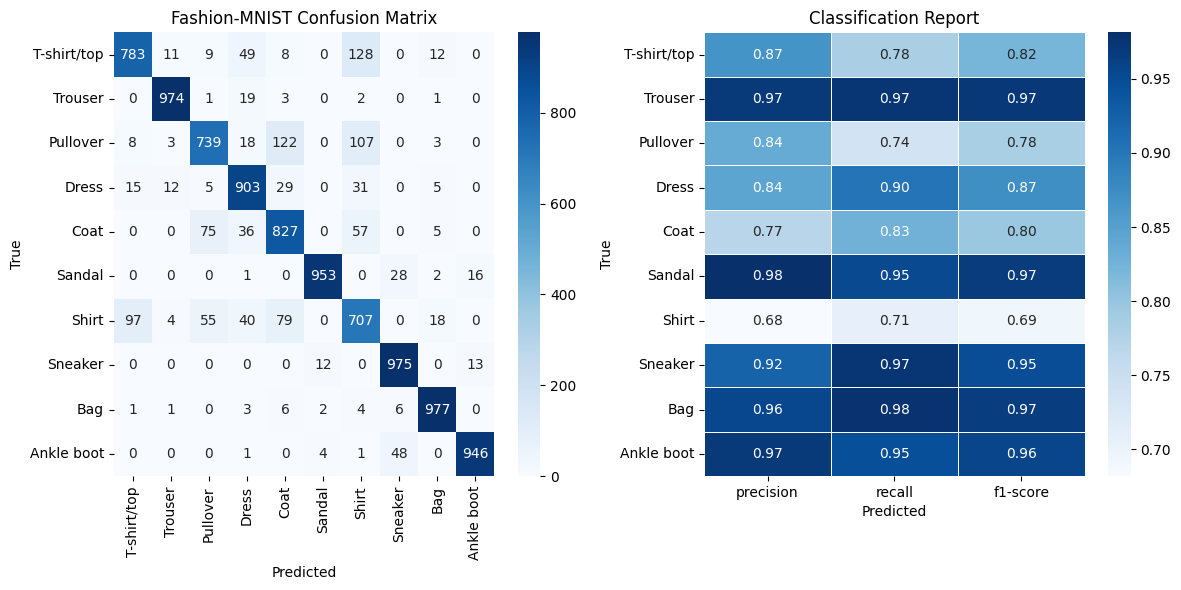

In [2]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.optim import Adam, AdamW
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  #Progress bars
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# In colab, you should ``change runtime type'' to GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#I have commented out code that can be swapped in to change the model or the entire model can be commented out and one of two others
#can be commented back in to generate figures that appear in the report. The last one that was run has been left. It was an AdamW test.

#Define the Neural Network
class FashionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.3)

        # self.fc1 = nn.Linear(28 * 28, 50)
        # self.fc2 = nn.Linear(50, 50)
        # self.fc3 = nn.Linear(50, 50)
        # self.fc4 = nn.Linear(50, 10)
        # self.dropout = nn.Dropout(0.3)

    #Activation Function
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    # def forward(self, x):
    #     x = self.flatten(x)
    #     x = F.gelu(self.fc1(x))
    #     x = self.dropout(x)
    #     x = F.gelu(self.fc2(x))
    #     x = self.dropout(x)
    #     x = F.gelu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x

model = FashionMLP().to(device)

criterion = nn.CrossEntropyLoss()
#Optimization Method
#optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = AdamW(model.parameters(), lr=1e-3)

#Training loop
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * X.size(0)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        #Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item() * X.size(0)
                val_correct += (outputs.argmax(1) == y).sum().item()
                val_total += y.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}: "
              f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

#Train the model
train_model(model, train_loader, val_loader, epochs=10)

# #Using CNN and MaxPool2d Layers
# class FashionCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.dropout = nn.Dropout(0.25)
#         self.fc1 = nn.Linear(64 * 14 * 14, 128)
#         self.fc2 = nn.Linear(128, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.dropout(x)
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x
# model = FashionCNN().to(device)

# criterion = nn.CrossEntropyLoss()
# #Optimization Method
# optimizer = Adam(model.parameters(), lr=1e-3)

# #Training loop
# def train_model(model, train_loader, val_loader, epochs=10):
#     for epoch in range(epochs):
#         model.train()
#         total_loss, correct, total = 0, 0, 0
#         for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             outputs = model(X)
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * X.size(0)
#             correct += (outputs.argmax(1) == y).sum().item()
#             total += y.size(0)

#         train_loss = total_loss / total
#         train_acc = correct / total

#         #Validation
#         model.eval()
#         val_loss, val_correct, val_total = 0, 0, 0
#         with torch.no_grad():
#             for X, y in val_loader:
#                 X, y = X.to(device), y.to(device)
#                 outputs = model(X)
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item() * X.size(0)
#                 val_correct += (outputs.argmax(1) == y).sum().item()
#                 val_total += y.size(0)

#         val_loss /= val_total
#         val_acc = val_correct / val_total

#         print(f"Epoch {epoch+1}: "
#               f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
#               f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# #Train the model
# train_model(model, train_loader, val_loader, epochs=10)

# #Preprocessing
# #Convert grayscale (1x28x28) to RGB (3x224x224)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1))  #grayscale to RGB
# ])

# class TransformedDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform
#     def __len__(self):
#         return len(self.dataset)
#     def __getitem__(self, idx):
#         x, y = self.dataset[idx]
#         if self.transform:
#             x = self.transform(x)
#         return x, y

# train_tf = TransformedDataset(train_ds, transform)
# val_tf   = TransformedDataset(val_ds, transform)
# test_tf  = TransformedDataset(test_ds, transform)

# train_loader = DataLoader(train_tf, batch_size=64, shuffle=True)
# val_loader   = DataLoader(val_tf, batch_size=128, shuffle=False)
# test_loader  = DataLoader(test_tf, batch_size=128, shuffle=False)

# #Load pretrained model
# model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# #Modify classifier for the 10 Fashion-MNIST classes
# for param in model.parameters():
#     param.requires_grad = False  #freeze all layers

# num_features = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(num_features, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, 10)
# )

# #Fine-tune last layers
# for param in model.fc.parameters():
#     param.requires_grad = True  #unfreeze classifier

# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

# #Training loop
# def train_model(model, train_loader, val_loader, epochs=5):
#     for epoch in range(epochs):
#         model.train()
#         total_loss, correct, total = 0, 0, 0
#         for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
#             X, y = X.to(device), y.to(device)
#             optimizer.zero_grad()
#             outputs = model(X)
#             loss = criterion(outputs, y)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item() * X.size(0)
#             correct += (outputs.argmax(1) == y).sum().item()
#             total += y.size(0)

#         train_loss = total_loss / total
#         train_acc = correct / total

#         #Validation
#         model.eval()
#         val_loss, val_correct, val_total = 0, 0, 0
#         with torch.no_grad():
#             for X, y in val_loader:
#                 X, y = X.to(device), y.to(device)
#                 outputs = model(X)
#                 loss = criterion(outputs, y)
#                 val_loss += loss.item() * X.size(0)
#                 val_correct += (outputs.argmax(1) == y).sum().item()
#                 val_total += y.size(0)

#         val_loss /= val_total
#         val_acc = val_correct / val_total

#         print(f"Epoch {epoch+1}: "
#               f"Train loss={train_loss:.4f}, acc={train_acc:.4f} | "
#               f"Val loss={val_loss:.4f}, acc={val_acc:.4f}")

# train_model(model, train_loader, val_loader, epochs=5)

#Evaluation on the Test Set
def evaluate_model(model, test_loader):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            test_loss += loss.item() * X.size(0)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= total
    test_acc = correct / total
    print(f"\nTest loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")
    return np.array(all_labels), np.array(all_preds)

#Run test evaluation
labels, preds = evaluate_model(model, test_loader)

#Confusion Matrix
cm = confusion_matrix(labels, preds)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

#Classification Report
CR = classification_report(labels, preds, target_names=class_names, output_dict=True)
if 'accuracy' in CR:
    del CR['accuracy']
if 'macro avg' in CR:
    del CR['macro avg']
if 'weighted avg' in CR:
    del CR['weighted avg']

#Joint Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(pd.DataFrame(CR).iloc[:-1, :].T, annot=True, ax=ax2, cmap='Blues', fmt='.2f', linewidths=.5)
ax2.set_title('Classification Report')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

sns.heatmap(cm, annot=True, ax=ax1, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
ax1.set_xlabel("Predicted")
ax1.set_ylabel("True")
ax1.set_title("Fashion-MNIST Confusion Matrix")

plt.tight_layout()
plt.show()

